<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/OffIMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running instructions

## imports

In [2]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt

#Get full dataset into dataframe


In [3]:
print(torch.__version__)
# !pip install torch==2.2.2

2.2.1+cu121


# Get and process data


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [5]:
# # plain vanilla transforms just to get my mean and std
# calc_transform = transforms.Compose([
#     transforms.Resize(128),
#     transforms.CenterCrop(116),
#     transforms.ToTensor()
# ])

# # Loading the dataset
# training_set = datasets.Flowers102(root='data', split='train', download=True, transform=calc_transform)
# valid_set = datasets.Flowers102(root='data', split='val', download=True, transform=calc_transform)

# # Combining datasets if I am allowed need to ask tomorrow
# combo_set = ConcatDataset([training_set, valid_set])
# combo_loader = DataLoader(combo_set, batch_size=16, shuffle=True)

# # Function to calculate mean and std
# def calc_mean_std(loader):
#     mean = 0.
#     std = 0.
#     total_images_count = 0

#     for images, _ in loader:
#         image_count_in_batch = images.size(0)
#         images = images.view(image_count_in_batch, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += image_count_in_batch

#     mean /= total_images_count
#     std /= total_images_count

#     return mean, std

# # Calculate mean and std
# mean, std = calc_mean_std(combo_loader)
# print(f'# transforms.Normalize(mean={mean}, std={std})')

In [6]:
data_train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(116),
    #transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205])),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(116),
    #transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205])),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(116),
    transforms.ToTensor()
])




In [7]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()




In [8]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_train_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_test_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_val_transform)


# creating data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)




100%|██████████| 344862509/344862509 [00:12<00:00, 27557606.51it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 268975.55it/s]


100%|██████████| 14989/14989 [00:00<00:00, 10197635.47it/s]


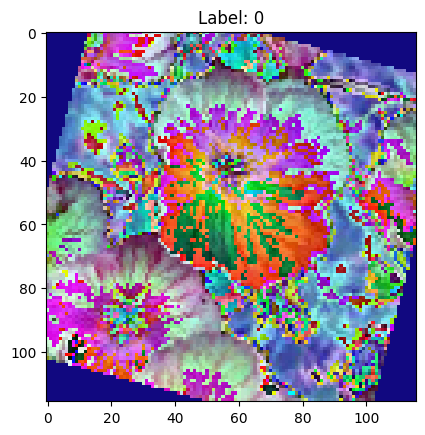

In [9]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# Test

# NN Architecture(Neural Network)


## define the model

In [10]:

# # 37% not too bad
# class ConvNN(nn.Module):
#     def __init__(self, hidden_units=128):
#         super(ConvNN, self).__init__()
#         self.hidden_units = hidden_units
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(hidden_units)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(hidden_units * 14 * 14, 512)
#         self.fc2 = nn.Linear(512, 102)
#         self.dropout2 = nn.Dropout(0.5)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = self.pool(x)
#         x = F.relu(self.conv4(x))
#         # print(x.shape)
#         x = x.view(-1, self.hidden_units * 14 * 14)  # flatten
#         x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x


# Simplified, for now it performs best

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 102)

    def forward(self, x):
        x = F.relu(self.bn1(self.pool(self.conv1(x))))
        x = F.relu(self.bn2(self.pool(self.conv2(x))))
        x = F.relu(self.bn3(self.pool(self.conv3(x))))
        # print(x.shape)
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(self.dropout1(x)))
        x = self.fc2(x)
        return x






# class ConvNN(nn.Module):
#     # def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#     #     super().__init__()
#     #     self.layer_stack = nn.Sequential(
#     #         nn.Flatten(), # neural networks like their inputs in vector form
#     #         nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
#     #         nn.Linear(in_features=hidden_units, out_features=output_shape)
#     #     )

#     # def forward(self, x):
#     #     return self.layer_stack(x)

#     def __init__(self, hidden_units=128):
#          super(ConvNN, self).__init__()
#          self.hidden_units=hidden_units
#          self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv4 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.bn1 = nn.BatchNorm2d(32)
#          self.bn2 = nn.BatchNorm2d(64)
#          self.bn3 = nn.BatchNorm2d(hidden_units)

#          self.pool = nn.MaxPool2d(2, 2, padding=0)
#          self.fc1 = nn.Linear(hidden_units * 14 * 14, 512)
#          self.fc2 = nn.Linear(512, 102)
#          # self.dropout1 = nn.Dropout(0.15)
#          self.dropout2 = nn.Dropout(0.5)




#         #x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         #x = self.pool(F.relu(self.bn2(self.conv2(x))))


#         #x = F.relu(self.fc1(x))
#         #
#         #x = self.fc2(x)
#         #return x
#         #x = self.flatten(x)
#         #logits = self.linear_relu_stack(x)
#         #return logits
#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         # x = F.relu(self.conv3(x))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu((self.conv4(x))))
#         x = self.pool(F.relu((self.conv5(x))))
#         x = self.pool(F.relu((self.conv6(x))))
#         x = self.pool(F.relu((self.conv7(x))))
#         x = self.pool(F.relu((self.conv8(x))))
#         # x = self.pool(F.relu(self.conv2(x)))

#         # print(x.shape)
#         x = x.view(-1, self.hidden_units * 14 * 14) # Flatten the output for the dense layer
#         x = F.relu(self.fc1(x))
#         # x = self.dropout1(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x





In [11]:
def train(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')

        # Time each batch processing
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
#model = ConvNN(hidden_units=128).to(device)
model = ConvNN().to(device)
print(model)

# LossFN
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Lower learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



ConvNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
)


# Train and Evaluation


In [14]:
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    if t >= 19:
      test(val_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Epoch 1, Batch 0, Loss: 4.5406
Time per batch: 1.70 seconds
Epoch 1, Batch 10, Loss: 4.4894
Epoch 1, Batch 20, Loss: 4.6328
Epoch 1, Batch 30, Loss: 4.5647
Epoch 1, Batch 40, Loss: 4.0485
Epoch 1, Batch 50, Loss: 4.3923
Epoch 1, Batch 60, Loss: 3.8906
Average Loss: 4.4602
Epoch 2
-------------------------------
Epoch 2, Batch 0, Loss: 3.7686
Time per batch: 1.74 seconds
Epoch 2, Batch 10, Loss: 3.6621
Epoch 2, Batch 20, Loss: 4.0647
Epoch 2, Batch 30, Loss: 3.5226
Epoch 2, Batch 40, Loss: 3.6240
Epoch 2, Batch 50, Loss: 3.9270
Epoch 2, Batch 60, Loss: 3.6449
Average Loss: 3.6970
Epoch 3
-------------------------------
Epoch 3, Batch 0, Loss: 3.1289
Time per batch: 1.57 seconds
Epoch 3, Batch 10, Loss: 3.1606
Epoch 3, Batch 20, Loss: 2.5598
Epoch 3, Batch 30, Loss: 2.8324
Epoch 3, Batch 40, Loss: 2.5011
Epoch 3, Batch 50, Loss: 3.0842
Epoch 3, Batch 60, Loss: 3.3358
Average Loss: 3.0896
Epoch 4
-------------------------------
Epoch 4, Batch 0, Los

KeyboardInterrupt: 

## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

## Set training parameters

## train

# Eval

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')
